In [1]:
import tensorflow as tf

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'archive',
    labels='inferred',
    shuffle=True,
    batch_size=32,
    image_size=(224, 224)
)

labels = dataset.class_names
labels = [label.replace('_', ' ').title() for label in labels]
print(labels)

Found 3100 files belonging to 31 classes.
['Chili  Healthy', 'Chili  Leaf Curl', 'Chili  Leaf Spot', 'Chili  Whitefly', 'Chili  Yellowish', 'Corn  Common Rust', 'Corn  Gray Leaf Spot', 'Corn  Healthy', 'Corn  Northern Leaf Blight', 'Mango  Diseased', 'Mango  Healthy', 'Pepper Bell  Bacterial Spot', 'Pepper Bell  Healthy', 'Potato  Early Blight', 'Potato  Healthy', 'Potato  Late Blight', 'Rice  Brown Spot', 'Rice  Healthy', 'Rice  Hispa', 'Rice  Leaf Blast', 'Rice  Neck Blast', 'Tomato  Bacterial Spot', 'Tomato  Early Blight', 'Tomato  Healthy', 'Tomato  Late Blight', 'Tomato  Leaf Mold', 'Tomato  Mosaic Virus', 'Tomato  Septoria Leaf Spot', 'Tomato  Spider Mites (Two Spotted Spider Mite)', 'Tomato  Target Spot', 'Tomato  Yellow Leaf Curl Virus']


In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [4]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255)
])

In [6]:
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                            include_top=False,
                                            weights='imagenet',
                                            pooling='avg',
                                            classifier_activation='softmax',
                                            classes=len(labels))

In [7]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 672ms/step - accuracy: 0.8055 - loss: 0.5658 - val_accuracy: 0.9097 - val_loss: 0.3090
Epoch 2/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 68s 672ms/step - accuracy: 0.8502 - loss: 0.4423 - val_accuracy: 0.9444 - val_loss: 0.2418
Epoch 3/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 68s 674ms/step - accuracy: 0.8717 - loss: 0.3730 - val_accuracy: 0.9375 - val_loss: 0.2526
Epoch 4/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 67s 653ms/step - accuracy: 0.9003 - loss: 0.2994 - val_accuracy: 0.9549 - val_loss: 0.1678
Epoch 5/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 689ms/step - accuracy: 0.9197 - loss: 0.2430 - val_accuracy: 0.9618 - val_loss: 0.1485
Epoch 6/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 67s 672ms/step - accuracy: 0.9413 - loss: 0.2007 - val_accuracy: 0.9826 - val_loss: 0.1135
Epoch 7/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 68s 682ms/step - accuracy: 0.9456 - loss: 0.1763 - val_accuracy: 0.9618 - val_loss: 0.1238
Epoch 8/13
77/77 ━━━━━━━━━━━━━━━━━━━━ 67s 673ms/step - accuracy: 0.9551 - loss: 0.1495 - val_accu

In [10]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    'archive/Pepper_bell__healthy/0ba474dd-0cfd-4fd2-a58c-8e3d18dbe7c3___JR_HL 8395.JPG', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image most likely belongs to Pepper Bell  Healthy with a 7.75 percent confidence.


In [11]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    'archive/Potato__early_blight/0a0744dc-8486-4fbb-a44b-4d63e6db6197___RS_Early.B 7575.JPG', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
This image most likely belongs to Potato  Early Blight with a 8.28 percent confidence.


In [15]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    'archive\Corn__gray_leaf_spot/0a403456-5c5e-4aad-aa89-a118175c6ddd___RS_GLSp 4501.JPG', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
This image most likely belongs to Corn  Gray Leaf Spot with a 8.31 percent confidence.


In [ ]:
y_preds = model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 354ms/step - accuracy: 0.0582 - loss: 3.7543


In [16]:
# classification report
from sklearn.metrics import classification_report
y_true = []
y_pred = []
for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(tf.argmax(model.predict(x), axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
                                                precision    recall  f1-score   support

                                Chili  Healthy       0.93      1.00      0.96        13
                              Chili  Leaf Curl       1.00      0.86      0.92        14
                              Chili  Leaf Spot       1.00      1.00      1.00        12
                               Chili  Whitefly       1.00      1.00      1.00         8
                              Chili  Yellowish       0.91      1.00      0.95        10
                             Corn  Common Rus

In [17]:
model.save('model_M_20.keras')

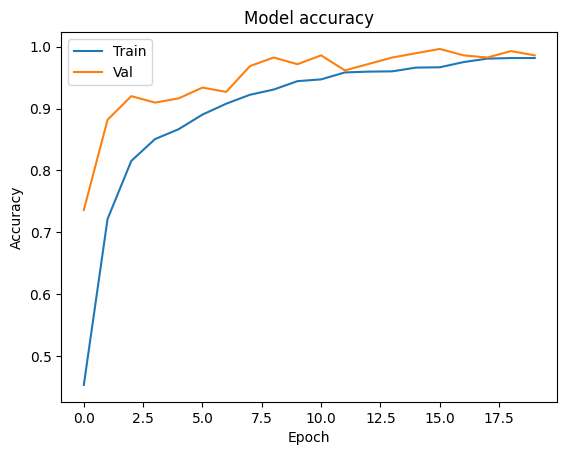

In [ ]:
# plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

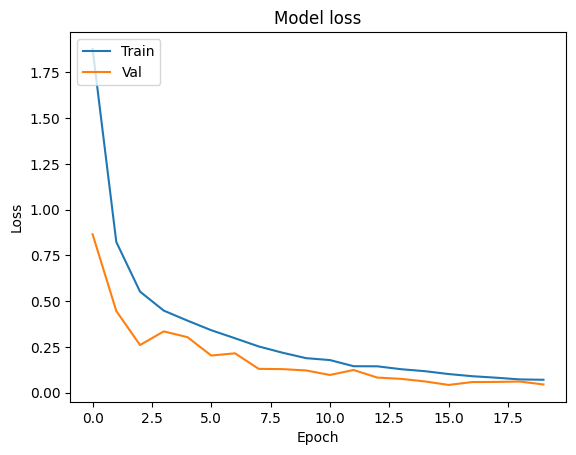

In [ ]:
# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()